In [6]:
import pandas as pd
from pathlib import Path  
import glob
import os
import re
import numpy as np
import ssl
import urllib
import pathlib
from tqdm import tqdm
import logging
import traceback
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#df_yourpaintings = pd.read_csv("../raw_data/yourpaintings/painting_dataset_2021.csv")
df_yourpaintings = pd.read_csv("https://www.robots.ox.ac.uk/~vgg/data/paintings/painting_dataset_2021.csv")

In [3]:
df_yourpaintings.head()

,Image URL,Web page URL,Subset,Labels
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow'
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train'
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train'
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train'
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse'


In [4]:
df_yourpaintings['Labels'].nunique()

89

# Try to find number of unique classes

In [5]:
#Extract filenames per URL for matching
for index, row in df_yourpaintings.iterrows():
    text = str(row["Image URL"])
    try:
        fname = text[text.rfind('/')+1:]
        df_yourpaintings.at[index,'filename']=fname    
    except Exception as e:
        logging.error(traceback.format_exc())

In [24]:
df_yourpaintings

,Image URL,Web page URL,Subset,Labels,filename
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg
...,...,...,...,...,...
8624,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/richard-je...,'test',' boat',OU_BLLI_4-001.jpg
8625,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-20094,'test',' boat',STF_STKMG_1965_FA_10-001.jpg
8626,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-norm...,'train',' bird',NY_YAG_YORAG_1030-001.jpg
8627,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/zebra-and-...,'train',' bird',GL_GM_A_1989_23_e-001.jpg


In [92]:
import pandas as pd
from urllib.request import Request, urlretrieve
from pathlib import Path  
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
BUCKET_NAME = 'art-api-sg'
#BUCKET_TRAIN_DATA_PATH = 'data/train_1k.csv'
BUCKET_TRAIN_DATA_PATH = 'yourpaintings'
PATH = Path("../raw_data")
PATH_YOURPAINTINGS = PATH/"yourpaintings"
MODEL_NAME = 'art-api'
MODEL_VERSION = 'baseline'
PATH_FILE = Path(PATH_YOURPAINTINGS/"df_yourpaintings.csv")  
PATH_FILE.parent.mkdir(parents=True, exist_ok=True)

In [34]:
test = df_yourpaintings[:20]
test

,Image URL,Web page URL,Subset,Labels,filename
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg
5,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/1st-south-...,'test',' horse',STF_STRM_832-001.jpg
6,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'test',' train',NY_NRM_1986_9418-001.jpg
7,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'test',' train',NY_NRM_2004_7349-001.jpg
8,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'train',' train',NY_NRM_1986_9421-001.jpg
9,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/264t-locom...,'test',' train',NY_NRM_1996_7374-001.jpg


In [221]:
IMG_SIZE = 255
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
])

In [101]:
len(imgs)

20

In [48]:
imgs = []

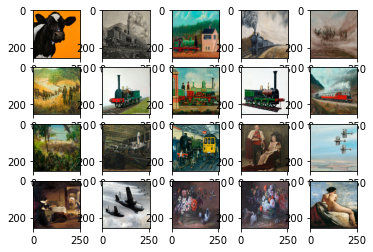

In [229]:
for index, row in test.iterrows():
    img_file = str(row["filename"])
    image = Image.open(os.path.join(PATH_YOURPAINTINGS, img_file))
    image = tf.convert_to_tensor(image)
    image = resize_and_rescale(image)
    ax = plt.subplot(4, 5, index + 1)
    plt.imshow(image)
    imgs.append(image)
    #imgs.append(np.array(image))

# rotate, flip, crop & copy the associated y values

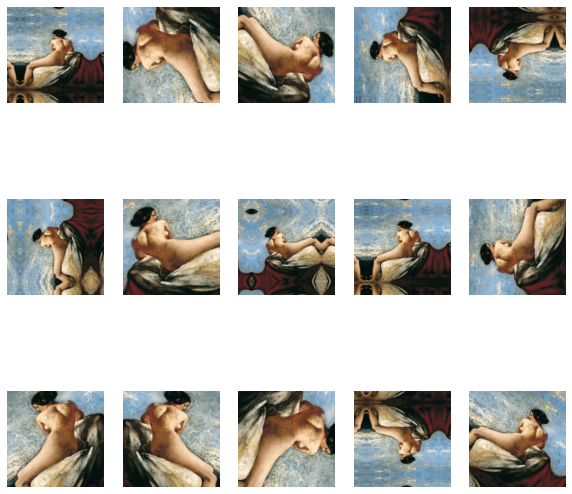

In [230]:
data_augmentation = tf.keras.Sequential([
#    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.4),
#    layers.CenterCrop(height = 100, width = 100)
    layers.RandomCrop(255, 255),
#    layers.Resizing(255, 255),
])

image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(15):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(augmented_image[0])
    aug.append(augmented_image[0])
    plt.axis("off")

In [204]:
len(aug)

30

In [205]:
aug = []

In [155]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
    
    # Batch all datasets.
    ds = ds.batch(batch_size)
    
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [158]:
train_ds = prepare(image, shuffle=True, augment=True)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'map'

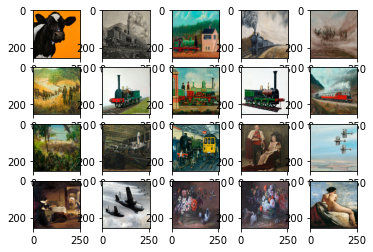

In [148]:
for index, row in test.iterrows():
    img_file = str(row["filename"])
    image = Image.open(os.path.join(PATH_YOURPAINTINGS, img_file))
    image = tf.convert_to_tensor(image)
    image = resize_and_rescale(image)
#    prepare(image, augment=True)
    ax = plt.subplot(4, 5, index + 1)
    plt.imshow(image)
    imgs.append(image)
    

In [131]:
i = random.randrange(0, 20)
image = imgs[i]
label = test.iloc[i]['Labels']
label

"' horse'"

In [134]:
augmented = augment(image, label)

In [138]:
plt.imshow(augmented.numpy())

AttributeError: 'tuple' object has no attribute 'numpy'

In [126]:
def augment(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)
    return image, label

In [74]:
img_height = 255
img_width = 255

In [75]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [122]:
import tensorflow_datasets as tfds 

def augment(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)
    return image, label

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
     with_info=True,
     as_supervised=True,)

train_ds = train_ds.shuffle(1000).map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/erniesg/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


NameError: name 'AUTOTUNE' is not defined

In [123]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [125]:
train_ds = train_ds.shuffle(1000).map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

ValueError: in user code:

    File "/tmp/ipykernel_2177/2966693961.py", line 5, in augment  *
        image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])

    ValueError: Dimensions must be equal, but are 4 and 3 for '{{node random_crop/GreaterEqual}} = GreaterEqual[T=DT_INT32](random_crop/Shape, random_crop/size)' with input shapes: [4], [3].


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'map'

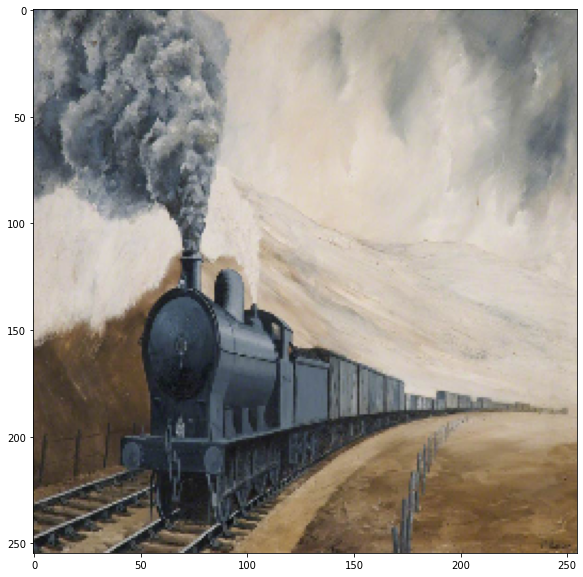

In [100]:
import random
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
plt.figure(figsize=(10, 10))

i = random.randrange(0, 20)
# for i in range(random.randrange(0, 20)):
#     print(i)
# for images in imgs[random.randrange(0, 20)]:
#     images
#     for i in range(9):
image = imgs[i]
#image = load_img(os.path.join(PATH_YOURPAINTINGS, img_file))
plt.imshow(image)
#image = image.map(lambda x, y: (data_augmentation(x), y))
#image = image.prefetch(tf.data.AUTOTUNE)
image = image.map(lambda x: data_augmentation(x))

# image=np.array(image)
# #image = tf.reshape(image, [256, 256, 3]) 
#augmented_images = data_augmentation(image)
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))

#plt.imshow(image)
# #     plt.axis("off")

In [107]:
test

,Image URL,Web page URL,Subset,Labels,filename
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg
5,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/1st-south-...,'test',' horse',STF_STRM_832-001.jpg
6,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'test',' train',NY_NRM_1986_9418-001.jpg
7,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'test',' train',NY_NRM_2004_7349-001.jpg
8,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'train',' train',NY_NRM_1986_9421-001.jpg
9,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/264t-locom...,'test',' train',NY_NRM_1996_7374-001.jpg


In [109]:
def _random_apply(func, x, p):
    return tf.cond(tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                           tf.cast(p, tf.float32)),
                   lambda: func(x),
                   lambda: x)


def _resize_with_pad(image):
    image = tf.image.resize_with_pad(image, target_height=200, target_width=200)
    return image


def augment(image):
    img = _random_apply(tf.image.flip_left_right, image, p=0.2)
    img = _random_apply(_resize_with_pad, img, p=1)
    return img

dataset = tf.data.Dataset.from_tensor_slices((imgs, test['Labels']))
dataset = augment(dataset)

#dataset.map(augment)

batch = next(iter(dataset))

ValueError: Attempt to convert a value (<TensorSliceDataset element_spec=(TensorSpec(shape=(255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>) to a Tensor.

Content --> tf.Tensor(b'This road was ok', shape=(), dtype=string)
Sentiment --> tf.Tensor(b'Neutral', shape=(), dtype=string)


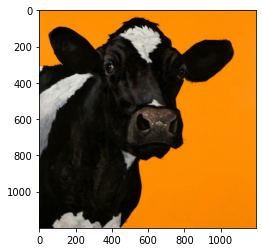

In [120]:
import numpy
from PIL import Image

for i in range(1, 3):
    imarray = numpy.random.rand(64,64,3) * 255
    im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
    im.save('result_image{}.png'.format(i))

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data= {'Location': ['some.txt', 'some-other.txt'], 
                         'Content': ['This road was ok', 'This was wonderful'],
                         'Score': [0.0353, -0.341],
                         'Sentiment': ['Neutral', 'Positive'],
                         'Image_location': ['../raw_data/yourpaintings/NID_QUB_QUB_264-001.jpg', '../raw_data/yourpaintings/GMIII_MOSI_A1978_72_3-001.jpg']})

features = df[['Content', 'Image_location']]
labels = df['Sentiment']

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
def process_path(x):
    content, image_path = x[0], x[1]
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    return content, img

dataset = dataset.map(lambda x, y: (process_path(x), y))

for x, y in dataset.take(1):
    content = x[0]
    image = x[1]
    print('Content -->', content)
    print('Sentiment -->', y)
    plt.imshow(image.numpy())

In [113]:
test

,Image URL,Web page URL,Subset,Labels,filename
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg
5,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/1st-south-...,'test',' horse',STF_STRM_832-001.jpg
6,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'test',' train',NY_NRM_1986_9418-001.jpg
7,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'test',' train',NY_NRM_2004_7349-001.jpg
8,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/222-locomo...,'train',' train',NY_NRM_1986_9421-001.jpg
9,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/264t-locom...,'test',' train',NY_NRM_1996_7374-001.jpg


In [118]:
features = test['filename']
labels = test['Labels']

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
def process_path(x):
    content, image_path = x[0], x[1]
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    return content, img

dataset = dataset.map(lambda x, y: (process_path(x), y))

for x, y in dataset.take(1):
    content = x[0]
    image = x[1]
    print('Content -->', content)
    print('Sentiment -->', y)
    plt.imshow(image.numpy())

ValueError: in user code:

    File "/tmp/ipykernel_2177/1397638778.py", line 11, in None  *
        lambda x, y: (process_path(x), y)
    File "/tmp/ipykernel_2177/1397638778.py", line 6, in process_path  *
        content, image_path = x[0], x[1]

    ValueError: Index out of range using input dim 0; input has only 0 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_STRING, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](args_0, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [], [1], [1], [1] and with computed input tensors: input[3] = <1>.


In [22]:
img = load_img(PATH_YOURPAINTINGS)

IsADirectoryError: [Errno 21] Is a directory: '/home/erniesg/code/erniesg/art_api/raw_data/yourpaintings'

In [21]:
batch_size = 32
img_height = 255
img_width = 255
img_ds = image_dataset_from_directory(
    directory=PATH_YOURPAINTINGS,
    labels=df_yourpaintings['Labels'].any(),
    batch_size=32,
    image_size=(256, 256))

ValueError: `labels` argument should be a list/tuple of integer labels, of the same size as the number of image files in the target directory. If you wish to infer the labels from the subdirectory names in the target directory, pass `labels="inferred"`. If you wish to get a dataset that only contains images (no labels), pass `labels=None`. Received: labels=True

In [8]:
for index, row in df_yourpaintings.iterrows():
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928


5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628


8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323


In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [ ]:
classes_list = []
words_pattern = '[a-z]+'

for index, row in df_yourpaintings.iterrows():
    text = row["Labels"]
    words_list = re.findall(words_pattern, text, flags=re.IGNORECASE)
    for word in words_list:
        classes_list.append(word)

unique_classes = set(classes_list)
print(f"The list of unique class labels contains {len(unique_classes)} labels, namely: {unique_classes}")

## Encode data for the relevant categories

### Start by adding the list of labels to a `label_classes` column

In [ ]:
for index, row in df_yourpaintings.iterrows():
    text = str(row["Labels"])
    words_list = re.findall(words_pattern, text, flags=re.IGNORECASE)
    df_yourpaintings.at[index, "label_classes"] = words_list

In [ ]:
print(type(df_yourpaintings.loc[10]['label_classes']))
print(df_yourpaintings.loc[10]['label_classes'])
print(df_yourpaintings.loc[15]['label_classes'])

<class 'list'>
['aeroplane', 'horse']
['chair', 'diningtable', 'dog']


In [ ]:
df_yourpaintings.iloc[15]
print(len(df_yourpaintings))

8629


### Apply MultipleLabelBinarizer on the `label_classes` column

In [ ]:
mlb = MultiLabelBinarizer()

test = df_yourpaintings['label_classes']

res = pd.DataFrame(mlb.fit_transform(test),
                   columns=mlb.classes_,
                   index=test.index)

res

,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
8624,0,0,1,0,0,0,0,0,0,0
8625,0,0,1,0,0,0,0,0,0,0
8626,0,1,0,0,0,0,0,0,0,0
8627,0,1,0,0,0,0,0,0,0,0


In [ ]:
res.head()

,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0


In [ ]:
merged = pd.concat([df_yourpaintings, res], axis=1)

In [ ]:
merged.head()

,Image URL,Web page URL,Subset,Labels,filename,label_classes,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg,[cow],0,0,0,0,1,0,0,0,0,0
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg,[train],0,0,0,0,0,0,0,0,0,1
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg,[train],0,0,0,0,0,0,0,0,0,1
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg,[train],0,0,0,0,0,0,0,0,0,1
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg,[horse],0,0,0,0,0,0,0,1,0,0


In [ ]:
merged["Image URL"].value_counts()

https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/OU/BLLI/OU_BLLI_4-001.jpg                193
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NID/QUB/NID_QUB_QUB_264-001.jpg            1
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/ABD/UA/ABD_UA_30191-001.jpg                  1
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/TWMS/LAG/TWMS_LAG_TWCMS_B6379-001.jpg      1
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NWM/FMS/NWM_FMS_PCF51-001.jpg              1
                                                                                                    ... 
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/GAC/GAC/GAC_GAC_14965-001.jpg                1
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/STF/STKMG/STF_STKMG_1967_FA_37-001.jpg       1
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/TATE/TATE/TATE_TATE_T06878_10-001.jpg        1
https://d3d00swyhr67nd.cloudfront.net/w800h800/collecti

In [ ]:
def get_your_paintings():
    PATH = pathlib.Path("../raw_data")
    yourpaintings_path = PATH/"yourpaintings"
    yourpaintings_path.mkdir(parents=True, exist_ok=True)
    urls = df_yourpaintings['Image URL'].tolist(); urls[:5]
    for url in urls[:5]:
        fname = url[url.rfind('/')+1:]
        print(f"the url for {url} is, and the filename is {fname}")
    return urls, yourpaintings_path

urls, yourpaintings_path = get_your_paintings()
urls = pd.Series(df_yourpaintings['Image URL'], dtype="string")
urls.dtype

the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NID/QUB/NID_QUB_QUB_264-001.jpg is, and the filename is NID_QUB_QUB_264-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/GMIII/MOSI/GMIII_MOSI_A1978_72_3-001.jpg is, and the filename is GMIII_MOSI_A1978_72_3-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NY/NRM/NY_NRM_1979_7964-001.jpg is, and the filename is NY_NRM_1979_7964-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/CHE/CRHC/CHE_CRHC_PCF40-001.jpg is, and the filename is CHE_CRHC_PCF40-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NOT/NTMAG/NOT_NTMAG_1997_31-001.jpg is, and the filename is NOT_NTMAG_1997_31-001.jpg


string[python]

In [ ]:
downloaded_urls_lst = []

def download(path, urls):
    # ignore SSL errors
    ssl._create_default_https_context = ssl._create_unverified_context
    for url in tqdm(urls):
        try:
            fname = url[url.rfind('/')+1:]
            downloaded_urls_lst.append(url)
            urllib.request.urlretrieve(url, path/fname)
        except Exception as e:
            logging.error(traceback.format_exc())
            
download(yourpaintings_path, urls)

  2%|▏         | 152/8629 [00:02<02:14, 63.10it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfind'

  4%|▍         | 380/8629 [00:05<02:01, 67.85it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfind'

  5%|▍         | 409/8629 [00:07<04:59, 27.44it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfind'

  5%|▌         | 458/8629 [00:07<02:20, 58.18it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfin

# Preprocess the images

In [ ]:
test = merged.copy()
imgs = []
img_path = "../raw_data/yourpaintings"

In [ ]:
for index, row in test.iterrows():
    img_file = str(row["filename"])
    try:
        image = Image.open(os.path.join(img_path, img_file))
        image = image.resize((256, 256))
        imgs.append(np.array(image))
        test.at[index, 'loaded'] = 1
    except Exception as e:
        logging.error(traceback.format_exc())    

ERROR:root:Traceback (most recent call last):
  File "<ipython-input-17-f6e12a6c1eec>", line 4, in <module>
    image = Image.open(os.path.join(img_path, img_file))
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/yourpaintings/nan'

ERROR:root:Traceback (most recent call last):
  File "<ipython-input-17-f6e12a6c1eec>", line 4, in <module>
    image = Image.open(os.path.join(img_path, img_file))
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/yourpaintings/nan'

ERROR:root:Traceback (most recent call last):
  File "<ipython-input-17-f6e12a6c1eec>", line 4, in <module>
    image = Image.open(os.path.join(img_path, img_file))
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp

In [ ]:
df_loaded = test.dropna(subset=['loaded'])

In [ ]:
df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8447 entries, 0 to 8628
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image URL      8447 non-null   object 
 1   Web page URL   8447 non-null   object 
 2   Subset         8447 non-null   object 
 3   Labels         8447 non-null   object 
 4   filename       8447 non-null   object 
 5   label_classes  8447 non-null   object 
 6   aeroplane      8447 non-null   int64  
 7   bird           8447 non-null   int64  
 8   boat           8447 non-null   int64  
 9   chair          8447 non-null   int64  
 10  cow            8447 non-null   int64  
 11  diningtable    8447 non-null   int64  
 12  dog            8447 non-null   int64  
 13  horse          8447 non-null   int64  
 14  sheep          8447 non-null   int64  
 15  train          8447 non-null   int64  
 16  loaded         8447 non-null   float64
dtypes: float64(1), int64(10), object(6)
memory usage: 1.

In [8]:
df = pd.read_csv(PATH_FILE)


In [ ]:
X = np.array(imgs)
X.shape

(8447, 256, 256, 3)

In [ ]:
y = df_loaded.drop(columns=['Image URL', 'Web page URL', 'Subset', 'Labels', 'label_classes', 'filename', 'loaded'])

In [ ]:
y.shape

(8447, 10)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = load_own_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 247, 247, 16)      4816      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        3

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size = 64, 
                    epochs = 50, 
                    callbacks=[es],
                    verbose=1)

Epoch 1/50
74/74 [==============================] - 15s 100ms/step - loss: 0.4085 - accuracy: 0.2066 - val_loss: 0.3459 - val_accuracy: 0.2342
Epoch 2/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3310 - accuracy: 0.2946 - val_loss: 0.3258 - val_accuracy: 0.3077
Epoch 3/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3170 - accuracy: 0.3208 - val_loss: 0.3158 - val_accuracy: 0.3204
Epoch 4/50
74/74 [==============================] - 5s 74ms/step - loss: 0.3088 - accuracy: 0.3381 - val_loss: 0.3102 - val_accuracy: 0.3128
Epoch 5/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3017 - accuracy: 0.3451 - val_loss: 0.3070 - val_accuracy: 0.3161
Epoch 6/50
74/74 [==============================] - 5s 71ms/step - loss: 0.2981 - accuracy: 0.3578 - val_loss: 0.3048 - val_accuracy: 0.3390
Epoch 7/50
74/74 [==============================] - 5s 71ms/step - loss: 0.2950 - accuracy: 0.3639 - val_loss: 0.3014 - val_accuracy: 0.3373
Epoch 8/50


In [ ]:
res = model.evaluate(X_test, y_test)
res

80/80 [==============================] - 2s 17ms/step - loss: 0.2912 - accuracy: 0.3751


[0.2911864221096039, 0.3751479387283325]

In [ ]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 38.0 %


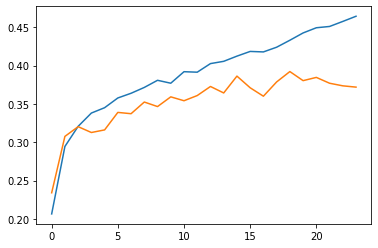

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
model.save(img_path)

In [ ]:
from matplotlib import pyplot as plt
classes_list = ["aeroplane", "bird", "boat", "chair",	"cow", "diningtable", "dog", "horse", "sheep", "train"]
ynew = model.predict(X_test)
# show the inputs and predicted outputs
for i in range(len(X_test)):
  if i < 300:
    plt.imshow(X_test[i], interpolation='nearest')
    plt.show()
    pred_dict = dict(zip(classes_list, ynew[i]))
    print(pred_dict)

# aeroplane	bird	boat	chair	cow	diningtable	dog	horse	sheep	train

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import accuracy_score
yhat = model.predict(X_test)
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(y_test, yhat)
# store result
print('>%.3f' % acc)
#results.append(acc)

>0.149


# Build a basic CNN architecture for benchmarking

In [ ]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(layers.Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Flatten())
benchmark_model.add(layers.Dense(128,activation='relu'))
benchmark_model.add(layers.Dense(6,activation='softmax'))
benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
benchmark_model.summary()

## Load VGG16 as baseline model

In [ ]:
def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [ ]:
model_homemade = load_own_model()
model_homemade.summary()

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model_homemade.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             batch_size = 16, 
                             epochs = 100, 
                             callbacks=[es])

In [ ]:
res = model_homemade.evaluate(X_test, y_test)
res

In [ ]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")